# Classification. Linear models and KNN

In [19]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [205]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import logging
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [4]:
PATH = "C:/Users/Maksim Voznyuk/Desktop/MV/Rolling Scope/ml-intro-2021/5_classification_linear_knn/"

In [6]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [62]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SexBool
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,1
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,1


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [13]:
Male = data.loc[data['Sex']=="male",'Sex'].count()
Female = data.loc[data['Sex']=="female",'Sex'].count() 
Male, Female

(577, 314)

In [15]:
Survived = data.loc[data['Survived']==1,'Survived'].count()
Dead = data.loc[data['Survived']==0,'Survived'].count() 
Survived, Dead

(342, 549)

In [35]:
#correlation between survival and gender
data['SexBool'] = data['Sex']
data['SexBool'].replace('male',0,inplace=True)
data['SexBool'].replace('female',1, inplace =True)

features = ['Survived', 'SexBool']

Matrix = data [features].corr()
Matrix


,Survived,SexBool
Survived,1.000000,0.543351
SexBool,0.543351,1.000000


Correlation between just two parameters - gender and survival, is not high, so we can make the conclusion that this two parameters are not strongly interconnected, in another words the propability of survival depends not onle from a gender of a passenger.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

mean age of survived passengers:  28.343689655172415
mean age of dead passengers:  30.62617924528302
median age of survived passengers:  28.0
median age of dead passengers:  28.0


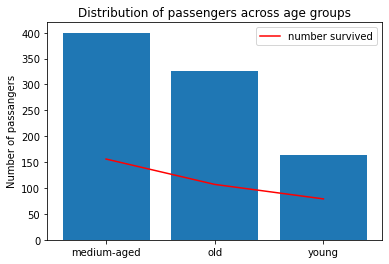

In [86]:
print("mean age of survived passengers: ",data['Age'][(data['Survived']==1)].mean())
print("mean age of dead passengers: ", data['Age'][(data['Survived']==0)].mean())
print("median age of survived passengers: ", data['Age'][(data['Survived']==1)].median())
print("median age of dead passengers: ",  data['Age'][(data['Survived']==0)].median())

data['age_group'] = data.apply(lambda x: 'young' if x['Age'] < 20 else 'medium-aged' if x['Age'] <= 40 else 'old', axis=1)
survived = data[data['Survived']==1].groupby('age_group')['age_group'].count().sort_index()

distr = data.groupby('age_group').count().max(axis=1)[['young', 'medium-aged', 'old']].sort_index()

plt.bar(distr.index, distr.values)
plt.plot(survived.index, survived.values,color='red', label ="number survived")

plt.ylabel('Number of passangers')
plt.title('Distribution of passengers across age groups')
plt.legend()
plt.show()


Medium aged persons (from 20 to 40 years old) more likely to survive than other age group

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

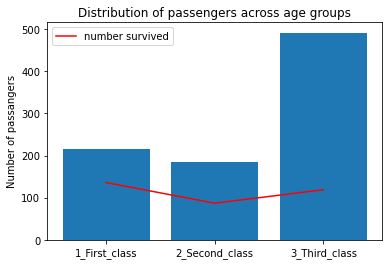

In [94]:
data['Class'] = data.apply(lambda x: '1_First_class' if x['Pclass'] == 1 else '2_Second_class' if x['Pclass'] == 2 else '3_Third_class', axis=1)

survived = data[data['Survived']==1].groupby('Class')['Class'].count().sort_index()
distr = data.groupby('Class').count().max(axis=1).sort_index()

plt.bar(distr.index, distr.values)
plt.plot(survived.index, survived.values,color='red', label ="number survived")

plt.ylabel('Number of passangers')
plt.title('Distribution of passengers across classes')
plt.legend()
 
plt.show()

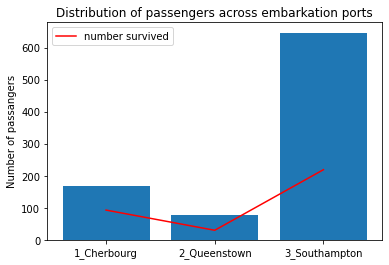

In [96]:
data['Onboarding'] = data.apply(lambda x: '1_Cherbourg' if x['Embarked'] == 'C' else '2_Queenstown' if x['Embarked'] == 'Q' else '3_Southampton', axis=1)

survived = data[data['Survived']==1].groupby('Onboarding')['Onboarding'].count().sort_index()
distr = data.groupby('Onboarding').count().max(axis=1).sort_index()

plt.bar(distr.index, distr.values)
plt.plot(survived.index, survived.values,color='red', label ="number survived")

plt.ylabel('Number of passangers')
plt.title('Distribution of passengers across embarkation ports')
plt.legend()
 
plt.show()

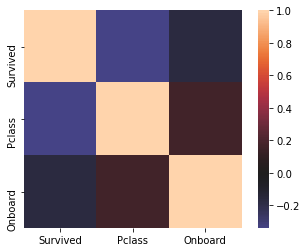

In [98]:
#correlation between survival and Pclass and embarkation
data['Onboard'] = data['Embarked']
data['Onboard'].replace('C',1,inplace=True)
data['Onboard'].replace('Q',2, inplace =True)
data['Onboard'].replace('S',3, inplace =True)

features = ['Survived', 'Pclass','Onboard']

from seaborn import heatmap

heatmap(data[features].corr(method='pearson'), center=0, square=True)
plt.show()

No direct and strong correlation between parameters, but the number of survived passangers is higher for group of passengers ondoarded in Southampton - because the full number of passengers onboarding is higher for the port in Southampton.
Also we can found from the grapth that the number of passengers survived is higher for fisrt-class ticket which may be explained by the location of rooms of the first-class - on the top of the ship. But this feature is not the main feature as the correlation is not very high.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [104]:
data.isnull().sum()/(data.count()+data.isnull().sum())*100

Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age           19.865320
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin         77.104377
Embarked       0.224467
SexBool        0.000000
age_group      0.000000
Class          0.000000
Onboarding     0.000000
Onboard        0.224467
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Answer:
For age we can fill all missing data with average age for the population, advantage of the method is that we can simply fill missing data with some average for our population data and the penalty for such simplification for the whole population will not be significant, main disadvantage of this method is that we can make our data too misstated or averaged in case when too much data is missing.
Another variant is to drop the data with missing values, but as a result we can drop too much and our model will make wrong predictions.

In our population column "Cabin" involve too much missing data so it will be more usefull to just drop the column from our dataset, as the column consist of text values and we will not be able to fill the data with some average meanings.

For embarkation port data - persantage of missing data is very small so we can just fill with the blanks with neigboring values and our population will not loose in quality.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [121]:
y = data['Survived']

In [135]:
#preparation of the data
data.fillna({'Age': data['Age'].mean()}, inplace=True)
data['Embarked'].fillna(method='ffill',inplace=True)
data['Onboard'].fillna(method='ffill',inplace=True)
data['Fare']  = data['Fare']*1

#selection of features
Features_X = data[['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked']]
Features_X_forCV = data[['Pclass','SexBool','Age','SibSp','Parch','Fare','Onboard']]


In [138]:
#cross-validation
from sklearn.model_selection import cross_val_score
from sklearn import svm
clf = svm.SVC(kernel='linear', C=1, random_state=42)
scores = cross_val_score(clf, Features_X_forCV, y, cv=10)
scores

array([0.81111111, 0.79775281, 0.76404494, 0.84269663, 0.79775281,
       0.7752809 , 0.76404494, 0.74157303, 0.80898876, 0.76404494])

In [231]:
X_train, X_test, y_train, y_test = train_test_split(Features_X_forCV.values, y.values, train_size=0.65, shuffle = True
                                                    , random_state=42)


In [232]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train % 2)

    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test % 2, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_, {"mean": mean, "std": std}

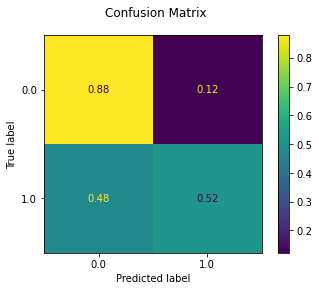

In [233]:
#KNN
knn_param_grid = {'n_neighbors': [1, 2, 3, 5, 30, 100], 'weights': ['uniform', 'distance']}
knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

knn_best_clf, knn_stats = fit_plot_confusion(knn_clf, X_train, y_train, X_test, y_test)

In [236]:
y_pred = knn_best_clf.predict(X_test)

In [237]:
metrics.accuracy_score(y_pred=y_pred, y_true=y_test % 2)

0.7339743589743589

In [238]:
#Logistic regression
lr_param_grid = {'C': [0.01, 0.1, 1.0, 10.0],
                 'penalty': ['l1', 'l2']}
lr_clf = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000, solver='saga', n_jobs=-1), lr_param_grid)

C:\Users\Maksim Voznyuk\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


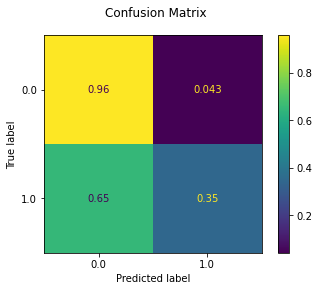

array([0.01807231])

In [239]:
lr_best_clf, lr_stats = fit_plot_confusion(lr_clf, X_train, y_train, X_test, y_test)
lr_best_clf.intercept_

In [240]:
y_pred = lr_best_clf.predict(X_test)

In [241]:
metrics.accuracy_score(y_pred=y_pred, y_true=y_test % 2)

0.7147435897435898

In [242]:
#Results are not very high, more feature selection work has to be done

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [243]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
StScalerData = scaler.fit_transform(Features_X_forCV)


In [279]:
X_train, X_test, y_train, y_test = train_test_split(StScalerData, y.values, train_size=0.649, shuffle = True, random_state=39)


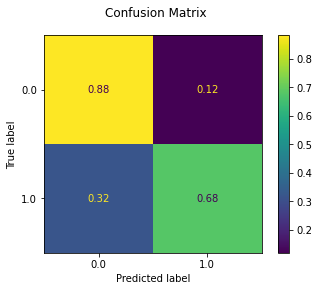

0.8115015974440895

In [280]:
lr_best_clf, lr_stats = fit_plot_confusion(lr_clf, X_train, y_train, X_test, y_test)
lr_best_clf.intercept_
y_pred = lr_best_clf.predict(X_test)
metrics.accuracy_score(y_pred=y_pred, y_true=y_test % 2)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.79 \leq score < 0.81,$$
$$ f(score) = 1.0, \ \ 0.81 \leq score < 0.83,$$ 
$$ f(score) = 2.5, \ \ 0.83 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [283]:
pd.read
pd.DataFrame(y_pred).to_csv('resultsMaksimVoznyuk.csv')
#сори, не успел:(( 
#но скор больше 0.81:)))

## Part 2: Porto Seguro’s Safe Driver Prediction

Let's build a model that predicts the probability that a driver will initiate an auto insurance claim in the next year.
Read the detailed description and download the dataset https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data. Put the data into *./data/porto/*.

In [14]:
insurance_data = pd.read_csv(os.path.join(PATH, 'porto', 'train.csv')).set_index('id')

In [15]:
insurance_data.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Let's skip EDA for now. We'll use SGDClassifier and build a simple baseline: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html.
Note that loss='log' gives logistic regression.

In [16]:
y = insurance_data['target']
X = insurance_data.drop(columns=['target'])

In [17]:
numeric_features = [column for column in X if not (column.endswith("cat") or column.endswith("bin"))]
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

categorical_features = [column for column in X if (column.endswith("cat") or column.endswith("bin"))]
categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', SGDClassifier(loss='log', alpha=0.001, n_jobs=-1, random_state=14))])

In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [19]:
clf = pipeline.fit(X_train, y_train)

We'll calculate the model accuracy:

In [20]:
accuracy_score(y_true=y_valid, y_pred=clf.predict(X_valid))

0.9631224658945812

Wow! Our model gets ~0.963 accuracy! But is it really good?...

Let's plot the confusion matrix and analyze the errors.

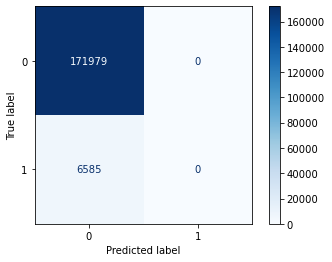

In [21]:
disp = plot_confusion_matrix(clf, X_valid, y_valid,
                             cmap=plt.cm.Blues,
                             normalize=None)

Well, it turns out that our model is completely useless. Let's calculate some basic statistics:

In [22]:
insurance_data.describe()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.036448,1.900378,1.358943,4.423318,0.416794,0.405188,0.393742,0.257033,0.163921,0.185304,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.187401,1.983789,0.664594,2.699902,0.493311,1.350642,0.488579,0.436998,0.370205,0.388544,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As you see, there are less than 4% of positive examples, so we have to deal with a highly imbalanced dataset.

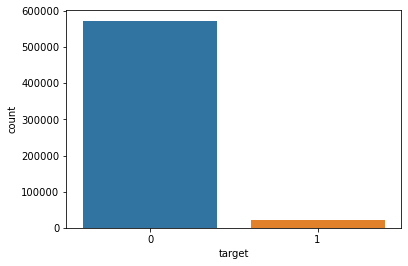

In [23]:
sns.countplot(x='target', data=insurance_data)
plt.show()

Accuracy is not informative here and the Normalized Gini Coefficient will be used instead: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/overview/evaluation.

In [24]:
# Code for calculating Normalized gini coefficient
# https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert(len(actual) == len(pred))  
    epsilon = 1e-7
    values = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)  
    values = values[np.lexsort((values[:, 2], -1 * values[:, 1]))]  
    total = values[:, 0].sum() 
    gini_sum = (values[:, 0].cumsum().sum() + epsilon) / (total + epsilon)  
  
    gini_sum -= (len(actual) + 1) / 2  
    return gini_sum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a)

**(1.5 points)** Prove that the **Normalized Gini Coefficient** is equivalent to **2 x AUC - 1** :

< your proof >

**(0.5 points)** By the way, what other metrics could you suggest for this problem?

< your thoughts >

Let's calculate the Normalized Gini Coefficient:

In [25]:
y_pred = clf.predict_proba(X_valid)[:, 1]

In [26]:
gini_normalized(y_valid, y_pred)

0.2558723581569817

**(0.5 points + Y bonus points)** Try different approaches: oversampling / undersampling, careful feature analysis and feature engineering, etc., to get a reasonable pipeline and improve the model quality. Use cross-validation for model evaluation.

Select the best model, load the test set and make the predictions. Submit them to kaggle.
Y bonus points will be calculated as $\frac{round(200 * \max(score - 0.253, 0))}{2}$, where *score* is your kaggle leaderboard score.

Note: do not use any classification models which have not been covered in the lessons yet.

In [27]:
## your code